# Building Intake-ESM datastores of ACCESS model output

This tutorial will demonstrate how users can build Intake-ESM datastores for their ACCESS model runs using the `access-nri-intake` Python package.

The ACCESS-NRI Intake Catalog consists of a set of intake-esm datastores, where a datastore has the result for one experiment. This tutorial focusses on <b>building one datastore for one experiment</b>. In general, it's assumed most user's wont build their own intake catalog, but could have several datastores for several experiments.

Note: The ACCESS-NRI Intake Catalog is curated by ACCESS-NRI with further information on its <a href="https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html" target="_blank">documentation website</a> and <a href="https://access-hive.org.au/model_evaluation/model_evaluation_model_catalogs" target="_blank">this ACCESS-Hive page</a>. It contains a set of model output shared amongst the ACCESS-NRI working groups, including CMIP6 results and ACCESS-OM2 (as typically used in Cosima Recipes). 

We demonstrate two methods here - first, the more involved method, which was the only way of building a datastore prior to the `access-nri-intake v1.1.1` release, and secondly, the convenience method added with that release.

In most cases, the convenience method will be preferable, but the more involved method can be useful as it affords a greater degree of control over the process.

----
# 1. The more involved method

A builder class is used for creating Intake-ESM datastores for each flavour of model output.  Classes for ACCESS model outputs are available in the `builders` submodule of the `access_nri_intake` Python package. 

We can list the available builders:

In [1]:
from access_nri_intake.source import builders

builders.__all__

['AccessOm2Builder',
 'AccessOm3Builder',
 'Mom6Builder',
 'AccessEsm15Builder',
 'AccessCm2Builder',
 'ROMSBuilder',
 'WoaBuilder']

Because we're looking at ACCESS-OM2 output, we'll typically use the `AccessOm2Builder` class. For other models, use the correct Builder

## Building the datastore

Building the Intake-ESM catalog should be as simple as passing the model run base output directory to the Builder and calling `.build()`. The build is parallelized (without dask) so will be faster if you throw more resources at it. The following was run using an Large `normal` ARE instance (12 cpus).

In [2]:
%%time

PATH = "/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6" #Some example ACCESS-OM2 output

builder = builders.AccessOm2Builder(
    path=PATH
).build()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/access_nri_intake/source/utils.py:241: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/access_nri_intake/source/utils.py:241: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/access_nri_intake/source/utils.py:241: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/access_nri_intake/source/utils.py:241: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25

CPU times: user 5.91 s, sys: 957 ms, total: 6.87 s
Wall time: 1min 11s


The previous cell builds the Intake-ESM datastore in memory. We'll want to save it somewhere so we can reuse and share it. The following cell will create two new files (a `.json` and `.csv` file) in your current work directory. These files are how Intake-ESM datastores are stored on disk.

In [3]:
builder.save(
    name="mydatastore", 
    description="An example datastore for ACCESS-OM2 ryf9091",
)

Successfully wrote ESM catalog json file to: file:///home/603/as2285/mydatastore.json


## Using your datastore

Now we can use our Intake-ESM datastore to query and load the model data - see also the Intake-ESM documentation [here](https://intake-esm.readthedocs.io/en/stable/index.html).

We can load the datastore directly using `intake`.

In [4]:
import intake

esm_datastore = intake.open_esm_datastore(
    "./mydatastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
filename,1473
path,2013
file_id,11
frequency,4
start_date,855
end_date,854
variable,338
variable_long_name,306
variable_standard_name,57
variable_cell_methods,6


It's easy to search for datasets in the datastore containing a particular variable and load them as xarray Datasets. (Note for analysing large datasets, you may want to first start a dask cluster).

In [5]:
ds = esm_datastore.search(variable="temp", frequency="1mon").to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


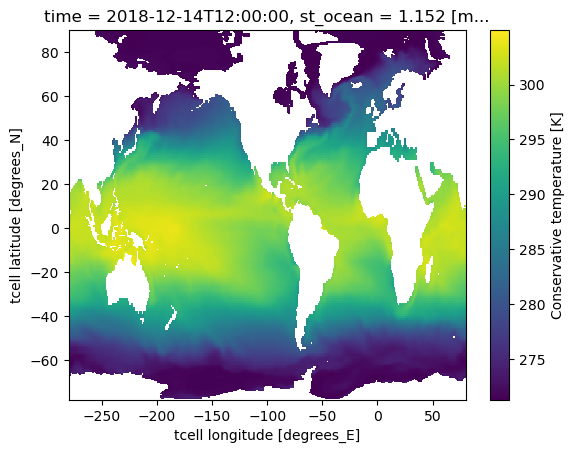

In [6]:
ds["temp"].isel(time=-1, st_ocean=0).plot()

If you think your ACCESS model data is worth sharing more widely, it might be a good idea to include it in the ACCESS-NRI Intake catalog. Please open an issue here to discuss: https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/new/choose

# 2. The convenience method: `use_datastore`


With the `access-nri-intake` v1.1.1 release, it is now possible to build and load datastores, all in a single step.
To do so, we use the `use_datastore` function.

The `use_datastore` function will check for a datastore in the directory you specify to place the catalog: `catalog_dir`. If one is found, it will verify whether it needs updating - for example, if a model run has been updated with new outputs. If so, the datastore will be updated and opened - if not, the existing datastore will be opened.

In [7]:
from access_nri_intake.experiment import use_datastore

help(use_datastore)

Help on function use_datastore in module access_nri_intake.experiment.main:

use_datastore(experiment_dir: pathlib.Path | str, builder: ecgtools.builder.Builder | None = None, catalog_dir: pathlib.Path | str | None = None, builder_kwargs: dict | None = None, open_ds: bool = True, datastore_name: str = 'experiment_datastore', description: str | None = None) -> intake_esm.core.esm_datastore | None
    Specify a builder and an experiment directory in order to build and/or open
    an esm-datastore in place for that experiment. Valid and up to date datastores
    will not be overwritten.
    
    Further configuration can be done by passing additional keyword arguments
    
    Parameters
    ----------
    builder : Builder
        The builder object that will be used to build the datastore.
    experiment_dir : Path | str
        The directory containing the experiment. If a string is passed, it will be
        converted to a Path object.
    catalog_dir : Path | str, optional
        Th

When calling `use_datastore`, you can:
1. Not specify `catalog_dir`. If you do so, the catalog will be built in the `experiment_dir`. 
   - If you follow this approach, we recommend *not* configuring `datastore_name` - this will default to `experiment_datastore`(`.json`). This can be handy if you want to build an esm-datastore that you want to add to the main access-nri intake catalog easily.
2. Specify `catalog_dir`. If you do so, we recommend:
    - Creating a directory somewhere that you wish to keep these esm-datastores - likely a subdirectory within your home directory.
    - Specifying `datastore_name` - all esm-datastores in the same directory must have unique names.


Approach 1. may be more useful if you a. know where the experiment output is located, and b. would like to add your output to the main catalog eventually.

Approach 2. may be more useful if you want to a. create a throwaway datastore, and b. have it be easily accessible whilst you work on it - and especially if you want to create multiple throwaway datastores. It may also be useful if you do not have write permissions to the directory where the model output is saved.

Note that in Approach 2, you will still require the experiment output path if you want to update the datastore - however, you can use the `intake.open_esm_datastore` method above to open it without checking for updates.

___

In this tutorial, we follow Approach 2, demonstrating how to build and update the same datastore above, saving it to a subdirectory within our home directory.

In [8]:
from pathlib import Path

EXPERIMENT_DIR = PATH # Path to experiment to catalog
BUILDER = builders.AccessOm2Builder # Builder for the model type run
CATALOG_DIR = Path("~/catalog_dir").expanduser() # We'll save our datastore in a directory called catalog_dir in our home dir
DATASTORE_NAME = "demo_datastore"

# If catalog_dir doesn't exist, make it. If there is a file called `catalog_dir`, we'll need to delete it.
if not CATALOG_DIR.exists() and not CATALOG_DIR.is_file():
    CATALOG_DIR.mkdir() 
elif CATALOG_DIR.exists() and CATALOG_DIR.is_file():
    raise RuntimeError("Please remove the file named 'catalog_dir' in your home directory")


esm_ds = use_datastore(
    builder=BUILDER,
    experiment_dir=EXPERIMENT_DIR,
    catalog_dir=CATALOG_DIR,
    datastore_name=DATASTORE_NAME
)

esm_ds

Generating esm-datastore for /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6
Building esm-datastore...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/access_nri_intake/source/utils.py:241: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/access_nri_intake/source/utils.py:241: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/access_nri_intake/source/utils.py:241: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/access_nri_intake/source/utils.py:241: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25

Sucessfully built esm-datastore!
Saving esm-datastore to /home/603/as2285/catalog_dir
Successfully wrote ESM catalog json file to: file:///home/603/as2285/catalog_dir/demo_datastore.json
Hashing catalog to prevent unnecessary rebuilds.
This may take some time...
Catalog sucessfully hashed!
Datastore sucessfully written to /home/603/as2285/catalog_dir/demo_datastore.json!
Please note that this has not added the datastore to the access-nri-intake catalog.
To add to catalog, please run 'scaffold_catalog_entry' for help on how to do so.


,unique
filename,1473
path,2013
file_id,11
frequency,4
start_date,855
end_date,854
variable,338
variable_long_name,11
variable_standard_name,11
variable_cell_methods,11


In [9]:
# If we run the function again, it should pick up our existing datastore - and not rebuild it, saving time! 
esm_ds = use_datastore(
    builder=BUILDER,
    experiment_dir=EXPERIMENT_DIR,
    catalog_dir=CATALOG_DIR,
    datastore_name=DATASTORE_NAME
)

esm_ds

Datastore found in /home/603/as2285/catalog_dir, verifying datastore integrity...
Parsing experiment dir...
Datastore integrity verified!
Datastore found in /home/603/as2285/catalog_dir/demo_datastore.json!
Please note that this has not added the datastore to the access-nri-intake catalog.
To add to catalog, please run 'scaffold_catalog_entry' for help on how to do so.


,unique
filename,1473
path,2013
file_id,11
frequency,4
start_date,855
end_date,854
variable,338
variable_long_name,11
variable_standard_name,11
variable_cell_methods,11


Note that you can additionally access this functionality from the terminal, using the `build-esm-datastore` tool:
___
```bash
$ module use /g/data/xp65/public/modules
$ module load conda/analysis3-25.02
$ build-esm-datastore --help
usage: build-esm-datastore [-h] [--builder BUILDER] [--builder-kwargs [BUILDER_KWARGS ...]] [--expt-dir EXPT_DIR] [--cat-dir CAT_DIR] [--datastore-name DATASTORE_NAME]
                           [--description DESCRIPTION]

Build an esm-datastore by inspecting a directory containing model outputs. If no datastore exists, a new one will be created. If a datastore exists, its integrity will be
verified, and the datastore regenerated if necessary.

options:
  -h, --help            show this help message and exit
  --builder BUILDER     Builder to use to create the esm-datastore. Builders are defined the source.builders module. Currently available options are: AccessOm2Builder,
                        AccessOm3Builder, Mom6Builder, AccessEsm15Builder, AccessCm2Builder. To build a datastore for a new model, please contact the ACCESS-NRI team.
  --builder-kwargs [BUILDER_KWARGS ...]
                        Additional keyword arguments to pass to the builder. Should be in the form of key=value.
  --expt-dir EXPT_DIR   Directory containing the model outputs to be added to the esm-datastore. Defaults to the current working directory. Although builders support adding
                        multiple directories, this tool only supports one directory at a time - at present.
  --cat-dir CAT_DIR     Directory in which to place the catalog.json file. Defaults to the value of --expt-dir if not set.
  --datastore-name DATASTORE_NAME
                        Name of the datastore to use. If not provided, this will default to 'experiment_datastore'.
  --description DESCRIPTION
                        Description of the datastore. If not provided, a default description will be used: 'esm_datastore for the model output in {--expt-dir}'

# Lets build the same datastore as above, but from the terminal

$ build-esm-datastore --builder AccessOm2Builder --expt-dir /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6 --cat-dir ~/catalog_dir

Datastore found in /home/189/ct1163/catalog_dir, verifying datastore integrity...
Parsing experiment dir...
Datastore integrity verified!
Datastore found in /home/189/ct1163/catalog_dir/experiment_datastore.json!
Please note that this has not added the datastore to the access-nri-intake catalog.
To add to catalog, please run 'scaffold-catalog-entry' for help on how to do so.
To open the datastore, run `intake.open_esm_datastore('/home/189/ct1163/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])` in a Python session.
   
```
___

Note that we only know *for sure, for every datastore* that the `variable` column has iterables in it - hence the instruction above. 

You can additionally use `qsub` to submit a build-esm-datastore job to the compute nodes: if you wish to build datastores from the terminal, this is the preferred way to do so. The sample PBS script below shows how to do this:

```bash
$ cat build_my_datastore.sh

#!/bin/bash -l

#PBS -P iq82
#PBS -l storage=gdata/xp65+gdata/ik11+gdata/cj50+gdata/p73+gdata/dk92+gdata/al33+gdata/rr3+gdata/fs38+gdata/oi10+gdata/hq89+gdata/py18+gdata/ig45+gdata/zz63+gdata/rt52 # Change these as necessary.
#PBS -q normal
#PBS -W block=true
#PBS -l walltime=00:10:00
#PBS -l mem=32gb
#PBS -l ncpus=7
#PBS -l wd
#PBS -j oe
#PBS -W umask=0022

# These PBS flags should give us resources comparable to a large ARE instance. You may need to change storage flags - these are the storage resources necessary to run end-to-end build tests for the catalog, so *should* cover your use case 



########################################################################################### 
# Copyright 2022 ACCESS-NRI and contributors. See the top-level COPYRIGHT file for details.
# SPDX-License-Identifier: Apache-2.0

# Description:
#   Generate access-nri intake datastore for a single experiment

###########################################################################################

set -e

module use /g/data/xp65/public/modules
module load conda/analysis3-25.02 
module load openmpi

build-esm-datastore --builder AccessOm2Builder --expt-dir /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6 --cat-dir ~/catalog_dir

$ qsub build_my_datastore.sh
```